In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import time


In [29]:
def load_calibration(file):
    """
    Parse calibration file containing camera intrinsics and stereo parameters.
    
    Args:
        file: Path to calibration file
        
    Returns:
        dict: Dictionary containing:
            - cam0: 3x3 numpy array (left camera intrinsic matrix)
            - cam1: 3x3 numpy array (right camera intrinsic matrix)
            - doffs: float (disparity offset)
            - baseline: float (stereo baseline in mm)
            - width: int (image width)
            - height: int (image height)
            - ndisp: int (number of disparities)
    """
    calib = {}
    
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            key, value = line.split('=')
            
            if key in ['cam0', 'cam1']:
                matrix_str = value.strip('[]')
                rows = matrix_str.split(';')
                matrix = []
                for row in rows:
                    matrix.append([float(x) for x in row.split()])
                calib[key] = np.array(matrix)
            elif key in ['width', 'height', 'ndisp']:
                calib[key] = int(value)
            else:  # doffs, baseline
                calib[key] = float(value)
    
    return calib

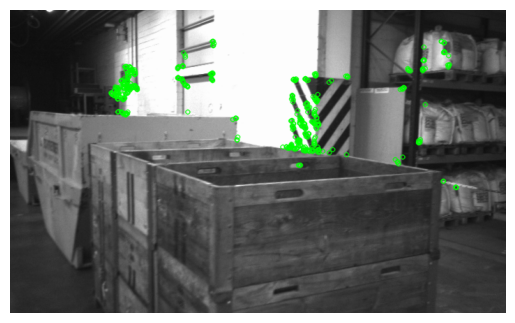

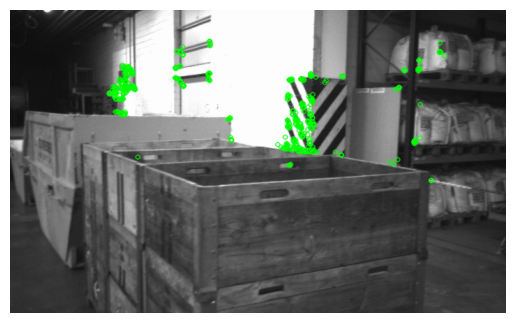

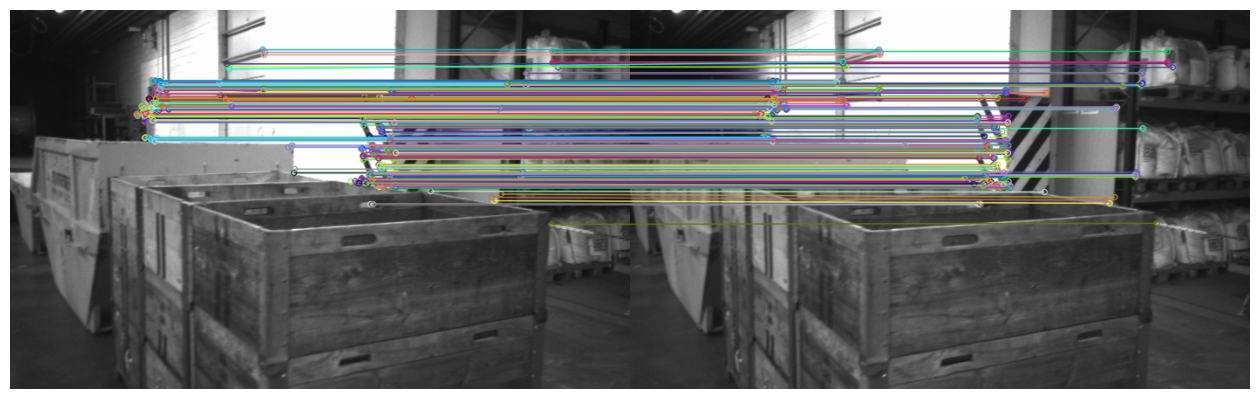

In [30]:
imgs = ['data/two-view/delivery_area_1s/im0.png','data/two-view/delivery_area_1s/im1.png']
calib = load_calibration('data/two-view/delivery_area_1s/calib.txt')

img0 = cv2.imread(imgs[0], cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread(imgs[1], cv2.IMREAD_GRAYSCALE)

# grayscale image
# feature detection + description
# feature matching
# two view geometry with RANSAC


# Initiate ORB detector
orb = cv2.ORB_create()
kp0,des0 = orb.detectAndCompute(img0, None)
kp1,des1 = orb.detectAndCompute(img1, None)

ro = cv2.drawKeypoints(img0, kp0, None, color=(0,255,0), flags=0)
r1 = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)

plt.axis('off'); plt.imshow(ro), plt.show()
plt.axis('off'); plt.imshow(r1), plt.show()

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des0, des1)
matches = sorted(matches, key=lambda x: x.distance)

img2 = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, ax = plt.subplots(figsize=(16, 10)); ax.axis('off'); ax.imshow(img2); plt.show()

In [ ]:
def evaluate_cheirality(projection_c0_to_c1, points3d_homogeneous):
    """
    Evaluate cheirality: check that 3D points are in front of both cameras.
    
    Args:
        projection_c0_to_c1: 3x4 projection matrix
        points3d_homogeneous: 4xN array of homogeneous 3D points
    
    Returns:
        tuple: (positive_count, total_points) - number of points with positive depth in both cameras
    """
    assert projection_c0_to_c1.shape == (3, 4)
    assert points3d_homogeneous.shape[0] == 4
    # Convert homogeneous to 3D coordinates
    points3d = points3d_homogeneous[:3] / points3d_homogeneous[3]
    
    # Depth in camera 1 (identity projection, so z coordinate)
    depth_c1 = points3d[2, :]
    
    # Transform points to camera 2 frame
    R = projection_c0_to_c1[:3, :3]
    t = projection_c0_to_c1[:3, 3:4]
    points3d_c2 = R @ points3d + t
    depth_c2 = points3d_c2[2, :]
    
    # Count points with positive depth in both cameras
    positive_mask = (depth_c1 > 0) & (depth_c2 > 0)
    positive_count = np.sum(positive_mask)
    
    return positive_count, points3d.shape[1]


def evaluate_reprojection(projection_c0_to_c1, points3d_homogeneous, p0, p1):
    """
    Evaluate reprojection error: compute average distance between observed and reprojected points.
    
    Args:
        projection_c0_to_c1: 3x4 projection matrix
        points3d_homogeneous: 4xN array of homogeneous 3D points
        p0: Nx2 array of normalized image points from camera 0
        p1: Nx2 array of normalized image points from camera 1
    
    Returns:
        float: Average reprojection error in normalized coordinates
    """
    assert projection_c0_to_c1.shape == (3, 4)
    assert points3d_homogeneous.shape[0] == 4
    assert p0.shape[0] == p1.shape[0]
    assert p0.shape[1] == 2
    assert p1.shape[1] == 2
    
    # Convert homogeneous to 3D coordinates
    points3d = points3d_homogeneous[:3] / points3d_homogeneous[3]
    
    # Reproject to camera 1 (identity projection)
    p1_reproj = points3d[:2, :].T / points3d[2:3, :].T
    
    # Reproject to camera 2
    R = projection_c0_to_c1[:3, :3]
    t = projection_c0_to_c1[:3, 3:4]
    points3d_c2 = (R @ points3d + t)
    p2_reproj = points3d_c2[:2, :].T / points3d_c2[2:3, :].T
    
    # Compute reprojection errors
    error1 = np.linalg.norm(p0 - p1_reproj, axis=1)
    error2 = np.linalg.norm(p1 - p2_reproj, axis=1)
    
    # Return average error
    return np.mean(error1 + error2)


from cv2 import UMat
k0 = UMat(calib['cam0'])
k1 = UMat(calib['cam1'])


points1 = np.array([kp0[m.queryIdx].pt for m in matches])
points2 = np.array([kp1[m.trainIdx].pt for m in matches])

[es, mask] = cv2.findEssentialMat(
  points1=points1, 
  points2=points2, 
  cameraMatrix=k0, 
  method=cv2.RANSAC)

(u,s,v) = np.linalg.svd(es)
print(u, s, v)
[R1, R2, t] = cv2.decomposeEssentialMat(es)
projection_w_to_c0 = np.identity(4)[:3]

projections_c0_to_c1 = [
  np.hstack((R1, t)),
  np.hstack((R1, -t)),
  np.hstack((R2, t)),
  np.hstack((R2, -t)),
]

points1_normalized = cv2.undistortPoints(points1.reshape(-1, 1, 2), k0, None) # Shape: Nx1x2
points2_normalized = cv2.undistortPoints(points2.reshape(-1, 1, 2), k1, None) # Shape: Nx1x2
p1_norm = points1_normalized.get().reshape(-1, 2).T  # Shape: 2xN
p2_norm = points2_normalized.get().reshape(-1, 2).T  # Shape: 2xN

# Find the valid projection by evaluating all candidates
valid_projection = None
best_score = -1
best_evaluation = None

for i, projection_c0_to_c1 in enumerate(projections_c0_to_c1):
    # Use normalized coordinates with normalized projection matrices
    points3d = cv2.triangulatePoints(projection_w_to_c0, projection_c0_to_c1, p1_norm, p2_norm)
    
    # Evaluate using modular functions
    cheirality_count, total_points = evaluate_cheirality(projection_c0_to_c1, points3d)
    reprojection_error = evaluate_reprojection(projection_c0_to_c1, points3d, p1_norm.T, p2_norm.T)
    
    print(f"Projection {i}: Cheirality: {cheirality_count}/{total_points}, "
          f"Reprojection error: {reprojection_error:.6f}")
    
    # Score: prioritize cheirality count, then low reprojection error
    # Only consider projections with reasonable cheirality (>50% positive)
    if cheirality_count > total_points * 0.5:
        score = cheirality_count - reprojection_error * 1000  # Weight reprojection error
        if score > best_score:
            best_score = score
            valid_projection = projection_c0_to_c1
            best_evaluation = {
                'cheirality_count': cheirality_count,
                'total_points': total_points,
                'reprojection_error': reprojection_error
            }

if valid_projection is not None:
    print(f"\nSelected projection with:")
    print(f"  Cheirality: {best_evaluation['cheirality_count']}/{best_evaluation['total_points']}")
    print(f"  Reprojection error: {best_evaluation['reprojection_error']:.6f}")
else:
    print("\nNo valid projection found!")


[[ 0.46870204  0.37929731 -0.79777938]
 [-0.72725324  0.678327   -0.10476263]
 [ 0.50141911  0.6292901   0.59377845]] [7.07106781e-01 7.07106781e-01 2.75527670e-13] [[ 0.38375939  0.67896979  0.62588238]
 [-0.47440597  0.72645617 -0.49719254]
 [ 0.79225483  0.10612003 -0.60089169]]
Projection 0: Cheirality: 0/408, Reprojection error: 0.000595
Projection 1: Cheirality: 0/408, Reprojection error: 0.000595
Projection 2: Cheirality: 341/408, Reprojection error: 0.000595
Projection 3: Cheirality: 67/408, Reprojection error: 0.000595

Selected projection with:
  Cheirality: 341/408
  Reprojection error: 0.000595
